# Post-process model output

In [8]:
%load_ext autoreload
%autoreload 2

In [24]:
import os
from glob import glob
import yaml

import cftime

import numpy as np
import xarray as xr
import dask

import matplotlib.pyplot as plt

import cesm_tools
import util

In [10]:
case = 'cam6327_sd.apo-forward.001'

In [11]:
os.getcwd()

'/glade/u/home/mclong/codes/cam-sd-cases/notebooks'

In [12]:
with open(f"caseinfo/{case}.yml") as fid:
    caseinfo = yaml.safe_load(fid)
    
srf_emis_files = caseinfo['srf_emis_files']    
archive_root = caseinfo['archive_root']    
sathist_fincl = caseinfo['sathist_fincl']    
archive_root

'/glade/p/eol/stephens/longcoll/archive/cam6327_sd.apo-forward.001'

In [13]:
with xr.open_dataset(caseinfo['ncdata']) as ds:
    background_ppm = ds.attrs['cam_i_add_uniform_fields_background_ppm']
background_ppm

400.0

In [14]:
data_vars = list(srf_emis_files.keys()) + sathist_fincl
data_vars

['apo_jena',
 'co2_cesm',
 'co2_gridfed',
 'co2_oco2mip',
 'co2_somffn',
 'n2_cesm',
 'n2_era',
 'o2_cesm',
 'o2_gk01r16',
 'o2_gridfed',
 'T',
 'U',
 'V',
 'Q',
 'PS',
 'Z3',
 'PBLH',
 'TMQ',
 'OMEGA']

In [15]:
files = sorted(glob(f"{archive_root}/atm/hist/{case}.cam.hs.*.nc"))
[os.path.basename(f) for f in files]

['cam6327_sd.apo-forward.001.cam.hs.1986-01-01-00000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-01-17-14400.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-11-04-81000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-11-12-18000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-11-22-07200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2010-04-01-07200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2010-04-13-84600.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-06-16-75600.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-06-26-14400.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-07-07-63000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-08-11-70200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-08-25-05400.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-09-04-00000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2014-10-20-19800.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2016-01-18-66600.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2016-01-30-79200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2016-02-18-77400.nc',
 'cam6327_sd.a

In [16]:
%%time
cam_dsets = []
for f in files:
    with xr.open_dataset(f) as ds:
        ds = ds.load()
        
        # convert units
        for v in data_vars:
            if v in srf_emis_files:
                ds[v] = cesm_tools.tracegas_convert_units(
                    ds[v],
                    srf_emis_files[v]["constituent"],
                    background_ppm=background_ppm,
                )        
        
        cam_dsets.append(ds)

CPU times: user 3.19 s, sys: 6.7 s, total: 9.89 s
Wall time: 12.7 s


In [17]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
campaign_keys = ["hip", "orc", "tom", "aoa"]

aircraft_files = {
    'hip': f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    'orc': f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    'tom': f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    'aoa': f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid.nc",
}

obspacks = {}
for key in campaign_keys:
    with xr.open_dataset(aircraft_files[key]) as dsi:
        dsi = dsi[['time', 'latitude', 'longitude', 'altitude', 'value']].load()
        
        for v in data_vars:
            if 'lev' in cam_dsets[0][v].dims:
                dsi[v] = xr.full_like(dsi.value, fill_value=np.nan)
            else:
                dsi[v] = xr.full_like(dsi.value, fill_value=np.nan)
                
            dsi[v].attrs = cam_dsets[0][v].attrs
            
        dsi['model_time'] = xr.full_like(dsi.time, fill_value=np.nan)
        obspacks[key] = dsi

obspacks['orc']

<xarray.Dataset>
Dimensions:      (obs: 40217)
Dimensions without coordinates: obs
Data variables: (12/25)
    time         (obs) datetime64[ns] 2016-01-05T19:19:59 ... 2016-03-01T22:4...
    latitude     (obs) float32 39.92 39.91 39.92 39.92 ... 39.89 39.9 39.9 39.9
    longitude    (obs) float32 -105.0 -105.0 -105.1 ... -105.1 -105.1 -105.1
    altitude     (obs) float32 2.191e+03 2.194e+03 ... 1.733e+03 1.707e+03
    value        (obs) float32 0.000404 0.000404 ... 0.0004117 0.0004117
    apo_jena     (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    PS           (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Z3           (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    PBLH         (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    TMQ          (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    OMEGA        (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    model_time   (obs) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
Attributes: (12/121)
    site_code:                                    ORC
    site_name:                                    ORCAS (O2/N2 Ratio and CO2 ...
    site_country:                                 Chile
    site_country_flag:                            CHIL0001.GIF
    site_latitude:                                -1e+34
    site_longitude:                               -1e+34
    ...                                           ...
    obspack_creation_date:                        2021-08-18T13:54:02.056239
    obspack_warning:                              Every effort is made to cre...
    obspack_fair_use:                             This cooperative data produ...
    obspack_usage_policy:                         www.gml.noaa.gov/ccgg/obspa...
    obspack_identifier_link:                      http://doi.org/10.25925/202...
    obspack_citation:                             Kenneth N. Schuldt, John Mu...

In [18]:
# proto vertical interpolation
def vertical_interpolation(da, z_from, z_to):
    """perform vertical interpolation on sathist ouput"""
    
    da_out = xr.full_like(da.isel(lev=-1), fill_value=np.nan)

    for i in range(da.sizes['ncol']):
        da_out[i] = np.interp(z_to[i], z_from[i, :], da[i, :])
    
    return da_out

def mb_vertical_interpolation(da, z_from, z_to):
    template = xr.full_like(da.isel(lev=-1), fill_value=np.nan)
    return xr.map_blocks(
        vertical_interpolation,
        da, 
        [z_from, z_to],
        template=template,
    )
    

In [23]:
cluster, client = util.get_ClusterClient()
cluster.scale(12)
client

/glade/work/mclong/miniconda3/envs/sno/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40018 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/40018/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/40018/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.33:46723,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/40018/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [27]:
%%time

# loop over obspack files
for n_key, obspack_key in enumerate(campaign_keys):

    # pull out the obspack data, dimensioned above
    obspack = obspacks[obspack_key]

    # loop over the sathist datasets    
    for ds in cam_dsets:
        
        # pull the indexes into the sathist file that are relevant
        # for this obsback_key
        ndx_sathist = np.where(ds.orbit_num == n_key)[0]
        if not len(ndx_sathist):
            continue

        # pull the indexes into the obspack file
        # for these columns in the sathist file
        ndx_obspack = ds.prof_num.values[ndx_sathist]            
        
        # vertical interpolation
        Z3 = ds.Z3.isel(ncol=ndx_sathist)                
        z_obs = obspack.altitude.isel(obs=ndx_obspack)
        
        delayed_objs = []
        for v in data_vars:
            if 'lev' in ds[v].dims:
                delayed_objs.append(
                    dask.delayed(vertical_interpolation)(
                        ds[v].isel(ncol=ndx_sathist),
                        Z3, 
                        z_obs,
                    )
                )
            else:
                obspack[v][ndx_obspack] = ds[v].isel(ncol=ndx_sathist).squeeze()
                
        computed_objs = dask.compute(*delayed_objs)
        
        i = 0
        for v in data_vars:
            if 'lev' in ds[v].dims:        
                obspack[v][ndx_obspack] = computed_objs[i]
                i += 1

CPU times: user 30.7 s, sys: 4.25 s, total: 34.9 s
Wall time: 5min 24s


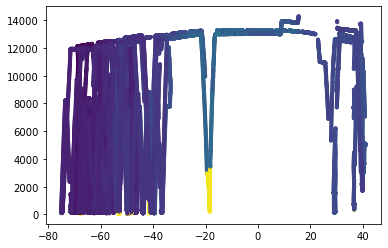

In [31]:
plt.scatter(
    obspacks['orc'].latitude,
    obspacks['orc'].altitude,
    c=obspacks['orc'].co2_cesm,
    s=10,
)